In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

D:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
transform = transforms.Compose(
    [torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))])

batch_size = 6000

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [3]:
from mnist import *
from viz import *

import torch
from torch.nn import Sequential, Module, CrossEntropyLoss
from torch.nn.functional import normalize
import numpy as np
from neurophoxTorch.torch import RMTorch
from scipy.stats import unitary_group
from tqdm import tqdm_notebook as pbar
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
def rc_mul(real: torch.Tensor, comp: torch.Tensor):
    return real.unsqueeze(dim=0) * comp


def cc_mul(comp1: torch.Tensor, comp2: torch.Tensor) -> torch.Tensor:
    real = comp1[0] * comp2[0] - comp1[1] * comp2[1]
    comp = comp1[0] * comp2[1] + comp1[1] * comp2[0]
    return torch.stack((real, comp), dim=0)

def phasor(real: torch.Tensor):
    return torch.stack((real.cos(), real.sin()), dim=0)


def cnorm(comp: torch.Tensor):
    return (comp[0] ** 2 + comp[1] ** 2).sqrt()


def cnormsq(comp: torch.Tensor):
    return comp[0] ** 2 + comp[1] ** 2


def to_complex_t(nparray: np.ndarray):
    return torch.stack((torch.as_tensor(nparray.real),
                        torch.as_tensor(nparray.imag)), dim=0)


class ElectroopticNonlinearity(Module):
    def __init__(self, alpha: float=0.1, g: float=0.05 * np.pi, phi_b: float=np.pi):
        super(ElectroopticNonlinearity, self).__init__()
        self.alpha = alpha
        self.g = g
        self.phi_b = phi_b

    def forward(self, inputs):
        phase = 0.5 * self.g * cnormsq(inputs) + 0.5 * self.phi_b
        return np.sqrt(1 - self.alpha) * cc_mul(rc_mul(phase.cos(), phasor(-phase)), inputs)


class CNormSq(Module):
    def __init__(self, normed=True):
        super(CNormSq, self).__init__()
        self.normed = normed

    def forward(self, inputs):
        return normalize(cnormsq(inputs), dim=1) if self.normed else cnormsq(inputs)

D:\ResearchProject\PNNRobustOptimization\OpenSourceCodes\System3-MZI Mesh\mnist.py:2: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  import scipy as sp


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.layer1 = RMTorch(64, phase_error = 0, phase_error_files = None,bs_error=0,bs_error_files = None)
        self.output = CNormSq()

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.norm3(x)
        x = self.fc2(x)
        x = torch.stack((x, torch.zeros(x.shape, dtype=torch.float32, device=x.device)), dim=0)
        x,_,_,_ = self.layer1(x)
        x = self.output(x)
        self.at_sensor_intensity = x
        return self.at_sensor_intensity[:,:10]
    
    def phy_forward(self,x):
        self.in_outs_phy = []
        with torch.no_grad():
            x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
            x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))
            x = x.view(x.size(0), -1) 
            x = self.fc1(x)
            x = self.norm3(x)
            x = self.fc2(x)
            x = torch.stack((x, torch.zeros(x.shape, dtype=torch.float32, device=x.device)), dim=0)
            x, _, _, _ = self.layer1(x)
            x = self.output(x)
            self.at_sensor_intensity_phy = x
        return self.at_sensor_intensity_phy[:,:10]    
    
    def phy_replace_sim(self):
        # PAT: replace the output
        with torch.no_grad():
            self.at_sensor_intensity.data.copy_(self.at_sensor_intensity_phy.data)    

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, -1, 1)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, -1, 1)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, -1, 1)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, -1, 1)
        # self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, -1, 1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net = LeNet5()
net.to(device)

cuda:0


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): RMTorch()
  (output): CNormSq()
)

In [9]:
[nenn, nepn, nenp, nepp], [enn, epn, enp, epp] = net.layer1.mesh_model.mzi_error_tensors()
[nenn_init, nepn_init, nenp_init, nepp_init] = [nenn, nepn, nenp, nepp]

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 400, gamma = 0.5)

In [11]:
bsE_scale = 0.15
phaseE_scale = 0.15

In [12]:
enn = np.load('.\MZI_Error/N64/bsE'+str(bsE_scale)+'/enn.npy')
epn = np.load('.\MZI_Error/N64/bsE'+str(bsE_scale)+'/epn.npy')
enp = np.load('./MZI_Error/N64/bsE'+str(bsE_scale)+'/enp.npy')
epp = np.load('./MZI_Error/N64/bsE'+str(bsE_scale)+'/epp.npy')
[nenn_n, nepn_n, nenp_n, nepp_n] = [enn, epn, enp, epp] ### Here, we copy the generated errors to nenn...

In [13]:
b0_theta_error = np.load('.\MZI_Error/N64/phaseE'+str(phaseE_scale)+'/theta.npy')
b0_phi_error = np.load('.\MZI_Error/N64/phaseE'+str(phaseE_scale)+'/phi.npy')
b0_theta_error = torch.tensor(b0_theta_error).to(device)
b0_phi_error = torch.tensor(b0_phi_error).to(device)

In [19]:
# Load models
PATH = './Training Results/01-Standard BP.pth'
PATH = './Training Results/02-PAT.pth'
PATH = './Training Results/03-SAT-In silico.pth'
PATH = './Training Results/04-SAT-In situ.pth'
PATH = './Training Results/05-DAT.pth'
PATH = './Training Results/06-NAT.pth'
net = LeNet5()
state_dict = torch.load(PATH)
state_dict = {k: v for k, v in state_dict.items() if 'cn1' not in k}
state_dict = {k: v for k, v in state_dict.items() if 'cn2' not in k}
state_dict = {k: v for k, v in state_dict.items() if 'cn3' not in k}
state_dict = {k: v for k, v in state_dict.items() if 'cn4' not in k}    
state_dict = {k: v for k, v in state_dict.items() if 'cn5' not in k}
state_dict = {k: v for k, v in state_dict.items() if 'cn6' not in k}       
net.load_state_dict(state_dict, strict=False)
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): RMTorch()
  (output): CNormSq()
)

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        net.layer1.theta.data = net.layer1.theta.data + b0_theta_error
        net.layer1.phi.data = net.layer1.phi.data + b0_phi_error
        net.layer1.nenn, net.layer1.nepn, net.layer1.nenp, net.layer1.nepp = \
                torch.as_tensor(nenn_n, dtype=torch.float32).cuda(), \
                    torch.as_tensor(nepn_n, dtype=torch.float32).cuda(), \
                torch.as_tensor(nenp_n, dtype=torch.float32).cuda(), \
                    torch.as_tensor(nepp_n, dtype=torch.float32).cuda()                    
        outputs = net.phy_forward(inputs)
        net.layer1.theta.data = net.layer1.theta.data - b0_theta_error
        net.layer1.phi.data = net.layer1.phi.data - b0_phi_error 
        net.layer1.nenn, net.layer1.nepn, net.layer1.nenp, net.layer1.nepp = \
                torch.as_tensor(nenn_init, dtype=torch.float32).cuda(), \
                    torch.as_tensor(nepn_init, dtype=torch.float32).cuda(), \
                torch.as_tensor(nenp_init, dtype=torch.float32).cuda(), \
                    torch.as_tensor(nepp_init, dtype=torch.float32).cuda() 
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy 10000 test images: {100 * correct / total} %')

Accuracy 10000 test images: 94.36 %


In [27]:
phaseE_sweep = np.linspace(0,0.20,4,endpoint=False)
bsE_sweep = np.linspace(0,0.20,4,endpoint=False)

In [28]:
accu_arr_sat = np.zeros((len(phaseE_sweep),len(bsE_sweep)))
for phaseE_ite in range(len(phaseE_sweep)):
    for bsE_ite in range(len(bsE_sweep)):
        phaseE = phaseE_sweep[phaseE_ite]
        bsE = bsE_sweep[bsE_ite]
        sweep_accu = []
        for ite in range(5):
            PATH = './Training Results/04-SAT-In situ.pth'
            net = LeNet5()
            state_dict = torch.load(PATH)
            state_dict = {k: v for k, v in state_dict.items() if 'cn1' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn2' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn3' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn4' not in k}    
            state_dict = {k: v for k, v in state_dict.items() if 'cn5' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn6' not in k}       
            net.load_state_dict(state_dict, strict=False)
            net.to(device)
            # PHASE ERROR Random generated
            b0_theta_error = torch.randn(net.layer1.theta.shape).cuda() * phaseE
            b0_phi_error = torch.randn(net.layer1.phi.shape).cuda() * phaseE
            net.layer1.theta.data = net.layer1.theta.data + b0_theta_error
            net.layer1.phi.data = net.layer1.phi.data + b0_phi_error
            # SPLITTER ERROR Random generated
            net.layer1.mesh_model.bs_error = bsE
            [nenn, nepn, nenp, nepp], [enn, epn, enp, epp] = net.layer1.mesh_model.mzi_error_tensors()
            net.layer1.nenn, net.layer1.nepn, net.layer1.nenp, net.layer1.nepp = \
                                torch.as_tensor(enn, dtype=torch.float32).cuda(), \
                                    torch.as_tensor(epn, dtype=torch.float32).cuda(), \
                                torch.as_tensor(enp, dtype=torch.float32).cuda(), \
                                    torch.as_tensor(epp, dtype=torch.float32).cuda()
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    # calculate outputs by running images through the network
                    outputs = net(inputs)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print(f'Accuracy 10000 test images: {100 * correct / total} %')
            sweep_accu.append(100 * correct / total)
        accu_arr_sat[phaseE_ite][bsE_ite] = np.mean(sweep_accu)
        print(f'PhaseE: {phaseE} BS: {bsE} Accu: {np.mean(sweep_accu)}')

Accuracy 10000 test images: 98.54 %
Accuracy 10000 test images: 98.54 %
Accuracy 10000 test images: 98.54 %
Accuracy 10000 test images: 98.54 %
Accuracy 10000 test images: 98.54 %
PhaseE: 0.0 BS: 0.0 Accu: 98.54
Accuracy 10000 test images: 98.55 %
Accuracy 10000 test images: 98.51 %
Accuracy 10000 test images: 98.55 %
Accuracy 10000 test images: 98.52 %
Accuracy 10000 test images: 98.56 %
PhaseE: 0.0 BS: 0.05 Accu: 98.538
Accuracy 10000 test images: 98.49 %
Accuracy 10000 test images: 98.55 %
Accuracy 10000 test images: 98.27 %
Accuracy 10000 test images: 98.53 %
Accuracy 10000 test images: 98.57 %
PhaseE: 0.0 BS: 0.1 Accu: 98.482
Accuracy 10000 test images: 98.2 %
Accuracy 10000 test images: 97.91 %
Accuracy 10000 test images: 97.72 %
Accuracy 10000 test images: 97.3 %
Accuracy 10000 test images: 98.32 %
PhaseE: 0.0 BS: 0.15000000000000002 Accu: 97.89000000000001
Accuracy 10000 test images: 98.58 %
Accuracy 10000 test images: 98.56 %
Accuracy 10000 test images: 98.48 %
Accuracy 10000 

In [30]:
accu_arr_dat = np.zeros((len(phaseE_sweep),len(bsE_sweep)))
for phaseE_ite in range(len(phaseE_sweep)):
    for bsE_ite in range(len(bsE_sweep)):
        phaseE = phaseE_sweep[phaseE_ite]
        bsE = bsE_sweep[bsE_ite]
        sweep_accu = []
        for ite in range(5):
            PATH = './Training Results/05-DAT.pth'
            net = LeNet5()
            state_dict = torch.load(PATH)
            state_dict = {k: v for k, v in state_dict.items() if 'cn1' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn2' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn3' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn4' not in k}    
            state_dict = {k: v for k, v in state_dict.items() if 'cn5' not in k}
            state_dict = {k: v for k, v in state_dict.items() if 'cn6' not in k}       
            net.load_state_dict(state_dict, strict=False)
            net.to(device)
            # PHASE ERROR Random generated
            b0_theta_error = torch.randn(net.layer1.theta.shape).cuda() * phaseE
            b0_phi_error = torch.randn(net.layer1.phi.shape).cuda() * phaseE
            net.layer1.theta.data = net.layer1.theta.data + b0_theta_error
            net.layer1.phi.data = net.layer1.phi.data + b0_phi_error
            # SPLITTER ERROR Random generated
            net.layer1.mesh_model.bs_error = bsE
            [nenn, nepn, nenp, nepp], [enn, epn, enp, epp] = net.layer1.mesh_model.mzi_error_tensors()
            net.layer1.nenn, net.layer1.nepn, net.layer1.nenp, net.layer1.nepp = \
                                torch.as_tensor(enn, dtype=torch.float32).cuda(), \
                                    torch.as_tensor(epn, dtype=torch.float32).cuda(), \
                                torch.as_tensor(enp, dtype=torch.float32).cuda(), \
                                    torch.as_tensor(epp, dtype=torch.float32).cuda()
            correct = 0
            total = 0
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for data in testloader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    # calculate outputs by running images through the network
                    outputs = net(inputs)
                    # the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print(f'Accuracy 10000 test images: {100 * correct / total} %')
            sweep_accu.append(100 * correct / total)
        accu_arr_dat[phaseE_ite][bsE_ite] = np.mean(sweep_accu)
        print(f'PhaseE: {phaseE} BS: {bsE} Accu: {np.mean(sweep_accu)}')

Accuracy 10000 test images: 94.18 %
Accuracy 10000 test images: 94.18 %
Accuracy 10000 test images: 94.18 %
Accuracy 10000 test images: 94.18 %
Accuracy 10000 test images: 94.18 %
PhaseE: 0.0 BS: 0.0 Accu: 94.18
Accuracy 10000 test images: 92.9 %
Accuracy 10000 test images: 93.33 %
Accuracy 10000 test images: 92.84 %
Accuracy 10000 test images: 93.89 %
Accuracy 10000 test images: 92.38 %
PhaseE: 0.0 BS: 0.05 Accu: 93.06800000000001
Accuracy 10000 test images: 93.36 %
Accuracy 10000 test images: 92.66 %
Accuracy 10000 test images: 93.0 %
Accuracy 10000 test images: 91.07 %
Accuracy 10000 test images: 93.21 %
PhaseE: 0.0 BS: 0.1 Accu: 92.66
Accuracy 10000 test images: 89.33 %
Accuracy 10000 test images: 87.89 %
Accuracy 10000 test images: 80.42 %
Accuracy 10000 test images: 83.88 %
Accuracy 10000 test images: 86.12 %
PhaseE: 0.0 BS: 0.15000000000000002 Accu: 85.52799999999999
Accuracy 10000 test images: 93.78 %
Accuracy 10000 test images: 91.83 %
Accuracy 10000 test images: 94.51 %
Accur

In [31]:
x_bs, y_ps = np.meshgrid(bsE_sweep, phaseE_sweep)

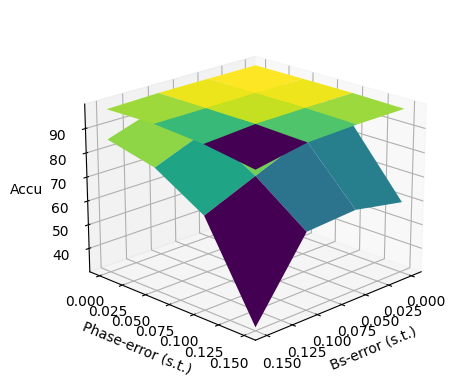

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个图形对象
fig = plt.figure()

# 添加3D子图
ax = fig.add_subplot(111, projection='3d')

# # 生成数据
# X = np.linspace(-5, 5, 100)
# Y = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(X, Y)
# Z = np.sin(np.sqrt(X**2 + Y**2))

# 绘制3D曲面图
ax.plot_surface(x_bs, y_ps, accu_arr_dat, cmap='viridis')
ax.plot_surface(x_bs, y_ps, accu_arr_sat, cmap='viridis')

# 设置轴标签
ax.set_xlabel('Bs-error (s.t.)')
ax.set_ylabel('Phase-error (s.t.)')
ax.set_zlabel('Accu')

# 调整视角
ax.view_init(elev=20, azim=45)  # 例如从20度仰角和-135度方位角观看

# 设置坐标轴放在图像内部
# ax.grid(False)
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # 隐藏网格平面颜色
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# 显示图像
plt.show()
